## Portfolio Evaluation
In this notebook, I evaluate the full portfolio strategy in a realisitic way.<br>
I use sharpe ratio that we have computed and recalculate it for weights re-optimization each day.<br>
This showcases a real-world portfolio simulation.

In [1]:
import pandas as pd
from pathlib import Path

# Load returns (only use the test period)
log_returns = pd.read_csv("data/processed/log_returns.csv", index_col="Date", parse_dates=True)

# Select test period (last 20% of dates)
split_idx = int(len(log_returns) * 0.8)
test_dates = log_returns.iloc[split_idx:].index

# Equal weights for each asset
tickers = log_returns.columns.tolist()
n_assets = len(tickers)
equal_weights = pd.DataFrame(
    1 / n_assets,
    index=test_dates,
    columns=tickers
)

# Save
Path("data/weights").mkdir(parents=True, exist_ok=True)
equal_weights.to_csv("data/weights/equal_weights.csv")
print("✅ Saved: data/weights/equal_weights.csv")

✅ Saved: data/weights/equal_weights.csv


In [2]:
import os
import sys
project_root = os.path.abspath(os.path.join(os.getcwd(), ".."))
sys.path.append(project_root)

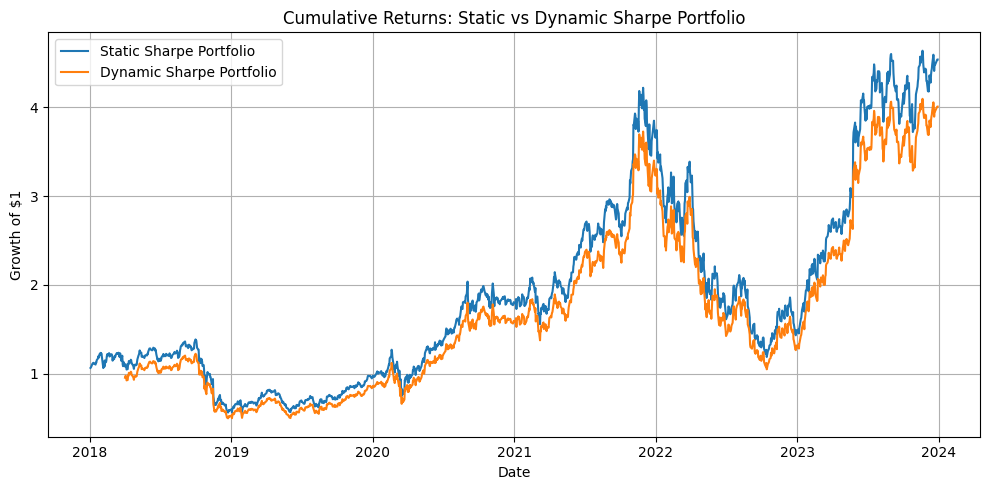

📊 Performance Comparison
         Annual Return  Volatility  Sharpe Ratio
Static          0.4699      0.5135        0.0473
Dynamic         0.4550      0.5153        0.0459


In [3]:
# --- Step 1: Load data ---
returns = pd.read_csv("data/processed/log_returns.csv", index_col="Date", parse_dates=True)
expected_static = pd.read_csv("data/expected/avg_up_returns.csv", index_col=0).squeeze()

# Expand static expected return into daily DataFrame
expected_daily = pd.DataFrame(
    [expected_static.values] * len(returns),
    columns=expected_static.index,
    index=returns.index
)

# --- Step 2: Load static weights ---
static_w = pd.read_csv("data/weights/sharpe_optimal_weights.csv", index_col=0).squeeze()
static_w_df = pd.DataFrame([static_w.values] * len(returns), columns=static_w.index, index=returns.index)

# --- Step 3: Generate dynamic weights (with static expected returns used daily) ---
from src.evaluation import generate_dynamic_weights, compute_portfolio_returns, compute_metrics

# Ensure both DataFrames use matching datetime index
returns.index = pd.to_datetime(returns.index)
expected_daily.index = pd.to_datetime(expected_daily.index)

# Make sure expected returns are aligned with returns
expected_daily = expected_daily.loc[returns.index]

dynamic_w = generate_dynamic_weights(returns, expected_daily, window=60)
dynamic_w.to_csv("data/weights/sharpe_dynamic_weights.csv")

# --- Step 4: Compute portfolio returns ---
static_r = compute_portfolio_returns(static_w_df, returns)
aligned_returns = returns.loc[dynamic_w.index]
dynamic_r = compute_portfolio_returns(dynamic_w, aligned_returns)

# --- Step 5: Cumulative returns ---
static_cum = (1 + static_r).cumprod()
dynamic_cum = (1 + dynamic_r).cumprod()

# --- Step 6: Plot ---
import matplotlib.pyplot as plt
from pathlib import Path

Path("results").mkdir(exist_ok=True)

plt.figure(figsize=(10, 5))
plt.plot(static_cum, label="Static Sharpe Portfolio")
plt.plot(dynamic_cum, label="Dynamic Sharpe Portfolio")
plt.title("Cumulative Returns: Static vs Dynamic Sharpe Portfolio")
plt.ylabel("Growth of $1")
plt.xlabel("Date")
plt.legend()
plt.grid()
plt.tight_layout()
plt.savefig("results/comparison_static_dynamic.png")
plt.show()

# --- Step 7: Metrics ---
metrics_df = pd.DataFrame({
    "Static": compute_metrics(static_r),
    "Dynamic": compute_metrics(dynamic_r)
}).T

print("📊 Performance Comparison")
print(metrics_df.round(4))
metrics_df.to_csv("results/static_vs_dynamic_metrics.csv")

The dynamic portfolio slightly underperform compared to the static one. This is unusual.<br>
Normally, the dynamic version of sharpe portfolio is more flexible than the static version because of its frequent re-optimization to match the current market condition.<br>
Nevertheless, here are some reasons that might cause underperformance of our dynamic portfolio:
- Covariance estimation, which dynamic optimization relies heavily on, can be noisy.
- In our dynamic strategy, we reused the same static expected return vector every day. Without updating this expectation over time, the dynamic strategy isn’t fully adapting to new information, which weakens its advantage.
